In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch as t
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision as tv
import torchvision.datasets as datasets 
import torchvision.transforms as transforms

c:\Users\sokmo\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\sokmo\AppData\Local\Programs\Python\Python39\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(), 
])

dataset_path = '../../datasets/mnist/handwritten_digits/'

mnist_trainset = datasets.MNIST(root=dataset_path, train=True, download=True, transform=transform)
train_loader = t.utils.data.DataLoader(mnist_trainset, batch_size=32, shuffle=True)

mnist_testset = datasets.MNIST(root=dataset_path, train=False, download=True, transform=transform)
test_loader = t.utils.data.DataLoader(mnist_testset, batch_size=32, shuffle=True)

One batch X:  torch.Size([32, 1, 28, 28])
One batch Y:  torch.Size([32])


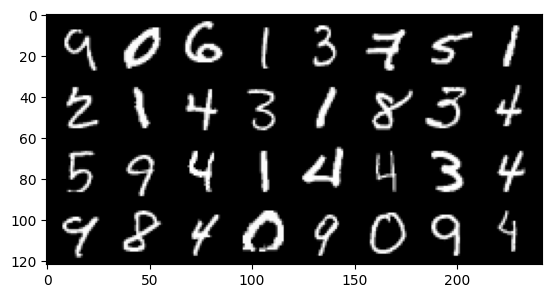

In [3]:
# one batch
one_batch_test = next(iter(train_loader))
one_batch_test_x = one_batch_test[0] # input
one_batch_test_y = one_batch_test[1] # labels

print("One batch X: ", one_batch_test_x.shape)
print("One batch Y: ", one_batch_test_y.shape)

one_batch_test_x_grid = tv.utils.make_grid(one_batch_test_x)
plt.imshow(one_batch_test_x_grid.numpy().transpose((1, 2, 0)))

In [4]:
print("Label: ", one_batch_test_y)

Label:  tensor([9, 0, 6, 1, 3, 7, 5, 1, 2, 1, 4, 3, 1, 8, 3, 4, 5, 9, 4, 1, 4, 4, 3, 4,
        9, 8, 4, 0, 9, 0, 9, 4])


In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # image size = 28x28
        self.conv1 = nn.Conv2d(1, 2, 3)  
        # image size = 26x26 x 2
        self.pool = nn.MaxPool2d(2, 2)
        # image size = 13x13 x 2
        self.layer1 = nn.Linear(13 * 13 * 2, 20)
        self.layer2 = nn.Linear(20, 10)

    def forward(self, batch_inputs):
        y = self.pool(self.conv1(batch_inputs))
        y = t.flatten(y, 1)
        y = self.layer1(y)
        y = self.layer2(y)
        # y = F.softmax(y, dim=1)
        return y

    def predict(self, single_image_input):
        y = self.forward(single_image_input.unsqueeze(0))
        return t.argmax(y, dim=1)
    
    def fit_batch(self, train_load, test_loader, loss_func, optimizer):
        self.train()
        for i, batch in enumerate(train_load):
            batch_x, batch_y = batch

            y_pred = self.forward(batch_x)
            loss = loss_func(y_pred, batch_y)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            if i % 200 == 0:
                print(f"Batch {i}/{len(train_load)}      training loss: {loss}")

        total_loss = 0
        self.eval()
        with t.no_grad():
            for i, batch in enumerate(test_loader):
                batch_x, batch_y = batch
                y_pred = self.forward(batch_x)
                loss = loss_func(y_pred, batch_y)
                total_loss += loss
        total_loss /= len(test_loader)
        print(f"Validation loss: {total_loss}")
        return total_loss

In [6]:
model = Net()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [7]:
# Load the model instead of training it
model.load_state_dict(t.load('./handwritten_model.pth'))

<All keys matched successfully>

In [14]:
epochs = 10

losses = []
for epoch in range(epochs):
    print(f"Epoch {epoch}/{epochs}")
    loss = model.fit_batch(train_loader, test_loader, loss_func, optimizer)
    losses.append(loss)

Epoch 0/10
Batch 0/1875      training loss: 2.26652193069458
Batch 200/1875      training loss: 0.4553509056568146
Batch 400/1875      training loss: 0.3962242007255554
Batch 600/1875      training loss: 0.3619592487812042
Batch 800/1875      training loss: 0.10375970602035522
Batch 1000/1875      training loss: 0.1436254382133484
Batch 1200/1875      training loss: 0.31642305850982666
Batch 1400/1875      training loss: 0.3121306598186493
Batch 1600/1875      training loss: 0.19836920499801636
Batch 1800/1875      training loss: 0.09326621145009995
Validation loss: 0.2861928343772888
Epoch 1/10
Batch 0/1875      training loss: 0.3723743259906769
Batch 200/1875      training loss: 0.2893669009208679
Batch 400/1875      training loss: 0.19447200000286102
Batch 600/1875      training loss: 0.17485257983207703
Batch 800/1875      training loss: 0.37601375579833984
Batch 1000/1875      training loss: 0.20375417172908783
Batch 1200/1875      training loss: 0.2349151074886322
Batch 1400/1875

In [8]:
plt.plot(losses)

NameError: name 'losses' is not defined

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

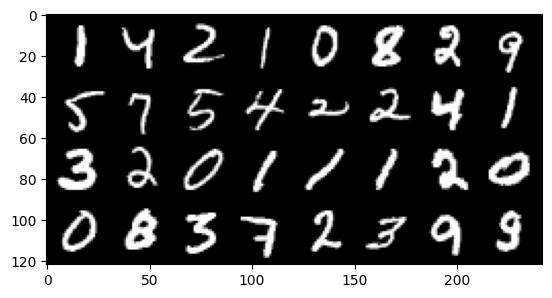

In [10]:
test = next(iter(test_loader))
test_images = tv.utils.make_grid(test[0])
plt.imshow(test_images.numpy().transpose((1, 2, 0)))

In [11]:
test_preds = model.forward(test[0])
test_preds = t.argmax(test_preds, dim=1)
print("Predictions: ", test_preds)
print("True labels: ", test[1])

Predictions:  tensor([1, 4, 2, 1, 0, 8, 2, 9, 5, 7, 5, 4, 6, 2, 4, 1, 3, 2, 0, 1, 1, 1, 2, 0,
        0, 8, 3, 7, 2, 3, 9, 9])
True labels:  tensor([1, 4, 2, 1, 0, 8, 2, 9, 5, 7, 5, 4, 2, 2, 4, 1, 3, 2, 0, 1, 1, 1, 2, 0,
        0, 8, 3, 7, 2, 3, 9, 9])


In [12]:
accuracy_score(test[1], test_preds)

0.96875

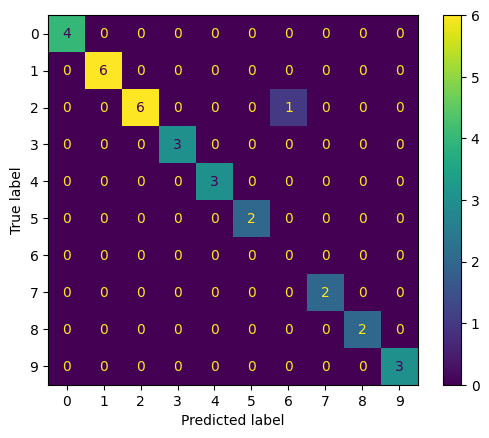

In [13]:
ConfusionMatrixDisplay(confusion_matrix(test[1], test_preds)).plot()

In [28]:
t.save(model.state_dict(), "./handwritten_model.pth")
t.onnx.export(model, t.randn(1, 1, 28, 28), "./handwritten.onnx")